In [1]:
import copy
import argparse
import pickle
import transformers
import mlflow
import logging
import pdb

import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset
import torch.nn as nn
import helpers
import models
import lossFunc
from train_hyper import train_hyper
from spl_utills import *

from sklearn.metrics import *

global_step = 0
moving_weights_all = None

In [2]:
def pre_train(model, train_loader, val_loader, args):
    lr = args.pre_lr
    epochs = args.pre_epochs
    n_warmup = args.pre_n_warmup
    if args.pre_optim == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=args.pre_wd)
    elif args.pre_optim == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8, weight_decay=args.pre_wd)
    else:
        raise ValueError(f'Invalid optimizer name {args.pre_optim}')
    if args.pre_cos:
        scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup,
                                                                 num_training_steps=epochs)
    else:
        scheduler = transformers.get_constant_schedule_with_warmup(optimizer, num_warmup_steps=n_warmup)

    history_loss = []
    history_acc = []

    best_val_model = copy.deepcopy(model.state_dict())
    best_val_acc = 0.

    for epoch in range(epochs):
        loss_meter = helpers.AverageMeter()
        pu_acc_meter = helpers.AverageMeter()
        pn_acc_meter = helpers.AverageMeter()
        model.train()
        for data, labels, true_labels in train_loader:
            optimizer.zero_grad()
            if args.cuda:
                data, labels, true_labels = data.cuda(), labels.cuda(), true_labels.cuda()

            net_out = model(data)

            if args.pre_loss == 'bce':
                loss = lossFunc.bce_loss(net_out, labels)
            else:
                loss = getattr(lossFunc, f'{args.pre_loss}_loss')(net_out, labels, args.prior, sur_loss=args.sur_loss)
            pu_acc = Metrics.accuracy(net_out, labels)
            pn_acc = Metrics.accuracy(net_out, true_labels)

            loss_meter.update(loss.item(), data.size(0))
            pu_acc_meter.update(pu_acc, data.size(0))
            pn_acc_meter.update(pn_acc, data.size(0))

            loss.backward()
            optimizer.step()

        val_loss, val_acc = test(model, val_loader, args)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_model = copy.deepcopy(model.state_dict())

        scheduler.step()

        print(
            f'Pre-Epoch [{epoch + 1} / {epochs}]  Loss: {loss_meter.avg:.5f}    PU-Acc: {pu_acc_meter.avg * 100.0:.5f}  PN-ACC: {pn_acc_meter.avg * 100.0:.5f}    val_loss: {val_loss:.5f}  val_acc: {val_acc * 100.0:.5f}')

        history_loss.append(loss_meter.avg)
        history_acc.append(pu_acc_meter.avg)

    history = {'loss': history_loss, 'acc': history_acc}
    model.load_state_dict(best_val_model)

    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(model.state_dict(),
               f'models/{args.dataset}_{args.prior}_{lr}_{epochs}_{args.pre_loss}_{args.pre_batch_size}.pth')
    return history

In [3]:
def test(model, loader, args):
    training = model.training
    model.eval()
    loss_meter = helpers.AverageMeter()
    acc_meter = helpers.AverageMeter()
    with torch.no_grad():
        for data, labels in loader:
            if args.cuda:
                data, labels = data.cuda(), labels.cuda()
            net_out = model(data)
            loss = lossFunc.bce_loss(net_out, labels)
            acc = Metrics.accuracy(net_out, labels)

            loss_meter.update(loss.item(), data.size(0))
            acc_meter.update(acc, data.size(0))

    model.train(training)
    return loss_meter.avg, acc_meter.avg


def get_fea(model, dataloader, args):
    training = model.training
    model.eval()
    fea_all = []
    true_labels_all = []
    labels_all = []
    with torch.no_grad():
        for data, labels, true_labels in dataloader:
            if args.cuda:
                data, labels, true_labels = data.cuda(), labels.cuda(), true_labels.cuda()

            net_out, fea = model(data, return_fea=True)
            fea_all.append(fea.cpu().numpy())
            labels_all.append(labels.cpu().numpy())
            true_labels_all.append(true_labels.cpu().numpy())
        fea_all = np.concatenate(fea_all, axis=0)
        labels_all = np.concatenate(labels_all, axis=0)
        true_labels_all = np.concatenate(true_labels_all, axis=0)
    model.train(training)
    return fea_all, labels_all, true_labels_all


def weighted_dataloader(model, dataloader, thresh, args):
    # calculate weights for all
    training = model.training
    model.eval()
    data_all, labels_all, true_labels_all, weights_all, probs_all = [], [], [], [], []
    global moving_weights_all
    with torch.no_grad():
        for data, labels, true_labels in dataloader:
            if args.cuda:
                data, labels, true_labels = data.cuda(), labels.cuda(), true_labels.cuda()
            net_out = model(data)

            # unlabeled data with linear weight
            probs = torch.sigmoid(net_out)
            probs_all.append(probs)
            # loss for calculating weight
            loss = lossFunc.logistic_loss(net_out / args.temper, -1)
            weights = calculate_spl_weights(loss.detach(), thresh, args)
            # positive data with weight=1.0
            weights[labels == 1] = 1.

            data_all.append(data)
            labels_all.append(labels)
            true_labels_all.append(true_labels)
            weights_all.append(weights)

        data_all = torch.cat(data_all, dim=0)
        labels_all = torch.cat(labels_all, dim=0)
        true_labels_all = torch.cat(true_labels_all, dim=0)
        weights_all = torch.cat(weights_all, dim=0)
        if moving_weights_all is None:
            moving_weights_all = weights_all
        else:
            moving_weights_all = args.phi * moving_weights_all + (1. - args.phi) * weights_all
        probs_all = torch.cat(probs_all, dim=0)

        unlabel_weights = moving_weights_all[labels_all == -1]
        unlabel_true_labels = true_labels_all[labels_all == -1]
        unlabel_probs = probs_all[labels_all == -1]
        logging.info(
            f'Mean weight of positive-unlabeled: {unlabel_weights[unlabel_true_labels == 1].mean()}\tMean weight of negative-unlabeled: {unlabel_weights[unlabel_true_labels == -1].mean()}')
        logging.info(
            f'Mean probability of positive-unlabeled: {unlabel_probs[unlabel_true_labels == 1].mean()}\tMean probability of negative-unlabeled: {unlabel_probs[unlabel_true_labels == -1].mean()}')

    dataloader = DataLoader(TensorDataset(data_all, labels_all, true_labels_all, moving_weights_all), shuffle=True,
                            batch_size=args.batch_size)
    model.train(training)
    return dataloader


def train_episode(model, dataloader, args):
    if args.optim == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
    else:
        optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=args.wd)
    if args.cos:
        scheduler = transformers.get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=args.n_warmup,
                                                                 num_training_steps=args.inner_epochs)
    else:
        scheduler = transformers.get_constant_schedule_with_warmup(optimizer, num_warmup_steps=args.n_warmup)

    # Test on training set before training
    model.eval()
    with torch.no_grad():
        meter = helpers.AverageMeter()
        for data, labels, true_labels, weights in dataloader:
            optimizer.zero_grad()
            if args.cuda:
                data, labels, true_labels, weights = data.cuda(), labels.cuda(), true_labels.cuda(), weights.cuda()

            net_out = model(data)

            # loss w.r.t. pseudo labels
            if args.loss == 'bce':
                loss = lossFunc.bce_loss(net_out, labels, weights)
            else:
                loss = getattr(lossFunc, f'{args.loss}_loss')(net_out, labels, args.prior, weights, sur_loss=args.sur_loss)
            meter.update(loss.item(), labels.size(0))
        logging.info(f'Loss before training: {meter.avg}')

    if args.restart:
        model.reset_para()

    model.train()

    tot_loss_meter = helpers.AverageMeter()
    tot_true_loss_meter = helpers.AverageMeter()
    tot_acc_meter = helpers.AverageMeter()
    for inner_epoch in range(args.inner_epochs):
        loss_meter = helpers.AverageMeter()
        for data, labels, true_labels, weights in dataloader:
            optimizer.zero_grad()
            if args.cuda:
                data, labels, true_labels, weights = data.cuda(), labels.cuda(), true_labels.cuda(), weights.cuda()

            net_out = model(data)

            # loss w.r.t. pseudo labels
            if args.loss == 'bce':
                loss = lossFunc.bce_loss(net_out, labels, weights, do_norm=False)
            else:
                loss = getattr(lossFunc, f'{args.loss}_loss')(net_out, labels, args.prior, weights, sur_loss=args.sur_loss)
            loss += args.w_entropy * lossFunc.entropy_loss(net_out)
            # loss w.r.t. true labels
            true_loss = lossFunc.bce_loss(net_out, true_labels, weights)
            # acc w.r.t. true labels
            acc = Metrics.accuracy(net_out, true_labels)

            tot_loss_meter.update(loss.item(), data.size(0))
            tot_acc_meter.update(acc, data.size(0))
            tot_true_loss_meter.update(true_loss.item(), data.size(0))

            loss.backward()
            optimizer.step()
            loss_meter.update(loss.item(), labels.size(0))

        scheduler.step()
        logging.debug(f'inner epoch [{inner_epoch + 1} / {args.inner_epochs}]  train loss: {loss_meter.avg}')

        if args.debug:
            global global_step
            mlflow.log_metric('train_loss', loss_meter.avg, global_step)
            global_step += 1

    return tot_loss_meter.avg, tot_acc_meter.avg, tot_true_loss_meter.avg


def train(model, positive_dataset, unlabeled_dataset, val_dataset, test_dataset, args):
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size_val, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)

    epochs = args.epochs
    batch_size = args.batch_size
    patience = args.patience
    positive_data, positive_labels = positive_dataset.X, positive_dataset.y
    unlabeled_data, unlabeled_labels = unlabeled_dataset.X, unlabeled_dataset.y

    # for SPL
    cl_scheduler = TrainingScheduler(args.scheduler_type, args.alpha, args.max_thresh, args.grow_steps, args.p,
                                     args.eta)

    history_loss = []
    history_acc = []
    history_true_loss = []
    history_val_loss = []
    history_val_acc = []

    val_best_acc = 0.
    val_best_index = -1
    val_best_model = copy.deepcopy(model.state_dict())

    fea_all = []

    for episode in range(epochs):
        # get next lambda
        thresh = cl_scheduler.get_next_ratio()
        helpers.prRedWhite(f'thresh = {thresh:.3f}')
        cur_data = torch.cat((positive_data, unlabeled_data), dim=0)
        cur_labels = torch.cat((positive_labels, -torch.ones_like(unlabeled_labels)), dim=0)
        cur_true_labels = torch.cat((positive_labels, unlabeled_labels), dim=0)
        perm = np.random.permutation(cur_data.size(0))
        cur_data, cur_labels, cur_true_labels = cur_data[perm], cur_labels[perm], cur_true_labels[perm]
        cur_loader = DataLoader(TensorDataset(cur_data, cur_labels, cur_true_labels), batch_size=batch_size,
                                shuffle=True)
        weighted_loader = weighted_dataloader(model, cur_loader, thresh, args)

        if args.vis and episode == 0:
            fea_all.append(get_fea(model, cur_loader, args))

        tot_loss, tot_acc, tot_true_loss = train_episode(model, weighted_loader, args)

        if args.vis:
            fea_all.append(get_fea(model, cur_loader, args))

        val_loss, val_acc = test(model, val_loader, args)
        test_loss, test_acc = test(model, test_loader, args)
        print(
            f'Episode [{episode + 1} / {epochs}]   Pseudo_Loss: {tot_loss:.5f}  True_Loss: {tot_true_loss:.5f}  True_Acc: {tot_acc * 100.0:.5f}   val_loss: {val_loss:.5f}  val_acc: {val_acc * 100.0:.5f}    test_loss: {test_loss: .5f}  test_acc: {test_acc * 100.0:.5f}')

        history_loss.append(tot_loss)
        history_acc.append(tot_acc)
        history_true_loss.append(tot_true_loss)
        history_val_loss.append(val_loss)
        history_val_acc.append(val_acc)

        if args.debug:
            mlflow.log_metric('val_loss', val_loss)
            mlflow.log_metric('val_err', 100.0 - val_acc * 100.0)

        # Early stop
        if val_acc > val_best_acc:
            val_best_acc = val_acc
            val_best_index = episode
            val_best_model = copy.deepcopy(model.state_dict())
        else:
            if episode - val_best_index >= patience:
                print(f'=== Break at epoch {val_best_index + 1} ===')
                fea_all = fea_all[:val_best_index + 2]
                break

    model.load_state_dict(val_best_model)

    if args.vis:
        if not os.path.exists('data_anal'):
            os.mkdir('data_anal')
        pickle.dump(fea_all, open(f'data_anal/{args.dataset}_{args.prior}.npy', 'wb'))

    history = {'pseudo_loss': history_loss, 'true_loss': history_true_loss, 'acc': history_acc,
               'val_loss': history_val_loss, 'val_acc': history_val_acc}

    return history


In [4]:

def prepare_and_run(args):
    seed_all(args.seed)
#     pdb.set_trace()
    positive_dataset, unlabeled_dataset, pretrain_dataset, val_dataset, test_dataset, input_size = get_datasets(
        args.dataset,
        args.n_labeled,
        args.n_unlabeled,
        args.prior,
        root=args.data_dir,
        n_valid=args.n_valid,
        n_test=args.n_test,
        return_pretrain=True)
    args.input_size = input_size
    
    model = getattr(models, args.model)(args.input_size)
    # if args.cuda:
    #     model = model.cuda()
    pdb.set_trace()
    if args.dataset == 'risk':
        model.train()
        train_loader = DataLoader(unlabeled_dataset, batch_size=args.batch_size_val, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
        cl_scheduler = TrainingScheduler(args.scheduler_type, args.alpha, args.max_thresh, args.grow_steps, args.p,
                                         args.eta)
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
        for epi in range(10):
            thresh = cl_scheduler.get_next_ratio()
            print(f'------- thresh: {thresh} ------------')
            for epo in range(20):
                model.train()
                for data, labels in train_loader:
                    # data, labels = data.cuda(), labels.cuda()
                    optimizer.zero_grad()
                    # data, label = data.cuda(), labels.cuda()
                    net_out = model(data).squeeze()
                    loss = lossFunc.bce_loss(net_out, labels)
                    weight = calculate_spl_weights(loss.detach(), thresh, args)
                    loss = lossFunc.bce_loss(net_out, labels, weight)
                    loss.backward()
                    optimizer.step()
                model.eval()
                acc_m = helpers.AverageMeter()
                with torch.no_grad():
                    for data, labels in test_loader:
                        # data, labels = data.cuda(), labels.cuda()
                        net_out = model(data).squeeze()
                        labels[labels == -1] = 0
                        acc = Metrics.accu(net_out, labels)
                        acc_m.update(acc, len(data))
                print(f'acc: {acc_m.avg}')

    if args.pretrained:
        print(f'Model loaded from: {args.pretrained}.')
        model.load_state_dict(torch.load(args.pretrained))
    else:
        val_loader = DataLoader(val_dataset, batch_size=args.batch_size_val, shuffle=False)
        pretrain_loader = DataLoader(pretrain_dataset, batch_size=args.pre_batch_size, shuffle=True)
        pre_train(model, pretrain_loader, val_loader, args)

    seed_all(args.seed)

    # Test before train
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size_val, shuffle=False)
    val_loss, val_acc = test(model, val_loader, args)
    un_loader = DataLoader(unlabeled_dataset, batch_size=args.batch_size_val, shuffle=False)
    un_loss, un_acc = test(model, un_loader, args)
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
    test_loss, test_acc = test(model, test_loader, args)
    helpers.prYellow(
        f'Before training  un-Loss: {un_loss:.5f}  un-Acc: {un_acc * 100.0: .5f}    val-Loss: {val_loss:.5f}  val-Acc: {val_acc * 100.0: .5f}   Test-Acc: {test_acc * 100.0:.5f}')

    if args.bilevel:
        history = train_hyper(model, positive_dataset, unlabeled_dataset, val_dataset, args)
    else:
        history = train(model, positive_dataset, unlabeled_dataset, val_dataset, test_dataset, args)

    test_loader = DataLoader(test_dataset, batch_size=args.batch_size_val, shuffle=False)
    test_loss, test_acc = test(model, test_loader, args)
    test_err = 1. - test_acc
    print(f'Test  Loss: {test_loss}   Error: {100.0 * test_err}')

    return history, test_loss, test_err


In [5]:
def main(parser):
#     pdb.set_trace()
    args = parser.parse_args(args=['--dataset','exp','--data_dir','data'])
    args.cuda = args.no_cuda
    logging.basicConfig(level=(logging.DEBUG if args.debug else logging.INFO))
    if args.run_all:
        args.debug = False

    if args.dataset == 'cifar10':
        args.model = 'CNN'
        args.n_labeled = 2000
        args.n_unlabeled = 4000
        args.n_valid = 500
        args.n_test = 5000
    elif args.dataset == 'mnist':
        args.model = 'normalNN'
        args.n_labeled = 2000
        args.n_unlabeled = 4000
        args.n_valid = 500
        args.n_test = 5000
    # for UCI datasets
    else:
        args.model = 'normalNN'
        args.n_labeled = 561
        args.n_unlabeled = 0
        args.n_valid = 100
        args.n_test = 200
        args.prior = 0.84

    if args.cuda:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
    
    if args.run_all:
        for prior in [0.2, 0.4, 0.6]:
            args.prior = prior
            test_losses = []
            test_errors = []

            for seed in range(10):
                args.seed = seed
                history, test_loss, test_err = prepare_and_run(args)

                test_losses.append(test_loss)
                test_errors.append(test_err)

            test_losses = np.array(test_losses)
            test_errors = np.array(test_errors)
            print(f'Test    Loss: {test_losses.mean()}   Error: {test_errors.mean() * 100.0}')

            mlflow.log_metric(f'test_err{prior}', test_errors.mean() * 100.0)

            print(f'--- prior: {args.prior}   Error: {test_errors.mean() * 100.0:.3f} ({test_errors.std():.3f}) ---')

    else:
        prepare_and_run(args)


if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='PyTorch Implementation of CL+PU')

    parser.add_argument('--debug', action='store_true')
    parser.add_argument('--vis', action='store_true')
    # Dirs
    parser.add_argument("--output_dir", type=str, default=os.getenv("AMLT_OUTPUT_DIR", "results"),
                        help='output dir (default: results)')
    parser.add_argument("--data_dir", type=str, default=os.listdir(os.getenv("AMLT_DATA_DIR", "./data")),
                        help="Directory where dataset is stored")
    # Dataset
    parser.add_argument('--dataset', type=str, choices=['cifar10', 'exp', 'mushroom', 'shuttle', 'spambase', 'risk'],
                        default='risk',
                        help='dataset name (default: mnist)')
    parser.add_argument('--seed', type=int, default=0, help='random seed (default: 0)')

    parser.add_argument('--n_labeled', type=int, default=1000, help='number of positive samples (default: 1000)')
    parser.add_argument('--n_unlabeled', type=int, default=0, help='number of unlabeled samples (default: 0)')
    parser.add_argument('--n_valid', type=int, default=100, help='number of valid samples (default: 50)')
    parser.add_argument('--n_test', type=int, default=200, help='number of valid samples (default: 150)')
    parser.add_argument('--prior', type=float, default=0.2,
                        help='ratio of unlabeled positive to unlabeled (default 0.2)')

    # GPU
    parser.add_argument('--no_cuda', action='store_true',
                        help='disable cuda (default: False)')
    parser.add_argument('--gpu_id', type=int, default=0,
                        help='set gpu id to use (default: 0)')

    # Pre-training
    parser.add_argument('--pre_optim', type=str, default='adam', choices=['adam', 'sgd'], help='name of optimizer for pre-training (default adam)')
    parser.add_argument('--pre_epochs', type=int, default=400,
                        help='number of pre-training epochs (default 400)')
    parser.add_argument('--pre_lr', type=float, default=1e-3, help='pre-training learning rate (default 1e-3)')
    parser.add_argument('--pre_wd', type=float, default=0., help='weight decay for pre-training (default 0.)')
    parser.add_argument('--pre_batch_size', type=int, default=64, help='batch size for pre-training (default 64)')
    parser.add_argument('--pre_n_warmup', type=int, default=0,
                        help='number of warm-up steps in pre-training (default 0)')
    parser.add_argument('--pre_cos', action='store_true',
                        help='Use cosine lr scheduler in pre-training (default False)')
    parser.add_argument('--pretrained', type=str, default=None,
                        help='pre-trained model path (default None)')

    # Training
    parser.add_argument('--epochs', type=int, default=100,
                        help='number of training epochs to run (default: 100)')
    parser.add_argument('--batch_size', default=64, type=int,
                        help='mini-batch size (default: 64)')
    parser.add_argument('--batch_size_val', default=128, type=int,
                        help='mini-batch size of validation (default: 128)')
    parser.add_argument('--optim', type=str, default='adam', help='type of optimizer for training (default: adam)')
    parser.add_argument('--lr', default=1e-4, type=float,
                        help='learning rate (default: 1e-4)')
    parser.add_argument('--wd', default=0., type=float, help='weight decay (default 0.)')
    parser.add_argument('--decay_epoch', default=-1, type=int,
                        help='Reduces the learning rate every decay_epoch (default -1)')
    parser.add_argument('--lr_decay', default=0.5, type=float,
                        help='Learning rate decay for training (default: 0.5)')
    parser.add_argument('--cos', action='store_true',
                        help='Use cosine lr scheduler (default False)')
    parser.add_argument('--n_warmup', default=0, type=int,
                        help='Number of warm-up steps (default: 0)')
    parser.add_argument('--patience', default=5, type=int, help='patience for early stopping (default 5)')
    parser.add_argument('--w_entropy', default=0, type=float, help='weight of entropy loss (default 0)')
    parser.add_argument('--restart', action='store_true', help='reset model before training in each episode (default: False)')

    # Test
    parser.add_argument('--run_all', action='store_true', help='run all experiences with 20 seeds (default False)')

    # CL
    parser.add_argument('--inner_epochs', type=int, default=1,
                        help='number of epochs to run after each dataset update (default: 1)')
    parser.add_argument('--max_thresh', type=float, default=2., help='maximum of threshold (default 2.0)')
    parser.add_argument('--grow_steps', type=int, default=10, help='number of step to grow to max_thresh (default 10)')
    parser.add_argument('--scheduler_type', type=str, default='exp',
                        choices=['const', 'exp', 'linear', 'rootp', 'geom'],
                        help='type of training scheduler (default exp)')
    parser.add_argument('--alpha', type=float, default=0.1, help='initial threshold (default 0.1)')
    parser.add_argument('--eta', type=float, default=1.1,
                        help='alpha *= eta in each step for scheduler exp (default 1.1)')
    parser.add_argument('--p', type=int, default=2, help='p for scheduler root-p (default 2)')
    parser.add_argument('--spl_type', type=str, default='linear',
                        choices=['hard', 'linear', 'log', 'mix2', 'logistic', 'poly', 'welsch', 'cauchy', 'huber', 'l1l2'],
                        help='type of soft sp-regularizer (default linear)')
    parser.add_argument('--mix2_gamma', type=float, default=1.0, help='gamma in mixture2 (default 1.0)')
    parser.add_argument('--poly_t', type=int, default=3, help='t in polynomial (default 3)')

    # BiLevel
    parser.add_argument('--outer_iters', type=int, default=5, help='number of hyper-parameter updates (default: 5)')
    parser.add_argument('--outer_lr', type=float, default=1e-2, help='lr for hyper-parameters (default: 1e-2)')
    parser.add_argument('--hyper_K', type=int, default=10,
                        help='the maximum number of conjugate gradient iterations (default: 10)')
    parser.add_argument('--warm_start', action='store_true',
                        help='whether to reuse params from previous hyper-iteration (default: False)')
    parser.add_argument('--bilevel', action='store_true', help='enable bilevel for hyper-parameter optimize')

    # PU
    parser.add_argument('--pre_loss', type=str, default='bce', choices=['bce', 'nnpu', 'upu'])
    parser.add_argument('--loss', type=str, default='bce')
    parser.add_argument('--sur_loss', type=str, default='sigmoid')
    parser.add_argument('--temper', type=float, default=1.0, help='temperature to smooth logits (default: 1.0)')
    parser.add_argument('--phi', type=float, default=0., help='momentum for weight moving average (default: 0.)')
#     print(parser.parse_args())
#     main(parser)


# train and test data

In [15]:
all_data = pd.read_excel("../data1/SQLServerData/SampleData - CurtMain.xlsx",sheet_name="LoanAllocation")
train_0_data = all_data[all_data["Approved"]==0].iloc[36:]
train_1_data = all_data[all_data["Approved"]==1].iloc[164:]
# pd.concat([train_0_data,train_1_data],axis=0).to_csv("data/train_data.csv")
test_0_data = all_data[all_data["Approved"]==0].iloc[:36]
test_1_data = all_data[all_data["Approved"]==1].iloc[:164]
# pd.concat([test_0_data,test_1_data],axis=0).to_csv("data/test_data.csv")

# LR

In [6]:
train_data , train_label ,_ = preprocess_uci_dataset('exp','./data')
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression()

lr_clf = lr_clf.fit(train_data[:800,],train_label[:800])
test_acc = sum(lr_clf.predict(train_data[800:,])==train_label[800:])/200
print(test_acc)

Dataset exp loading.
0.845


In [21]:
confusion_matrix(train_label[800:],np.ones(200))

array([[  0,  31],
       [  0, 169]], dtype=int64)

In [23]:
print(classification_report(train_label[800:],np.ones(200)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.84      1.00      0.92       169

    accuracy                           0.84       200
   macro avg       0.42      0.50      0.46       200
weighted avg       0.71      0.84      0.77       200



D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# NN

In [7]:
# 数据增强
train_data , train_label ,_ = preprocess_uci_dataset('exp','./data')
# train_data = np.delete(train_data,list(range(270,614,1))+list(range(1200,1342,1)),1)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)

Dataset exp loading.


# PCA

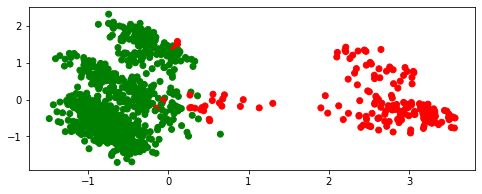

In [8]:
import pylab

import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
pca= PCA(n_components=64) 
pca_100d = pca.fit_transform(train_data)
c_ = {0:'r',1:'g'}
color = [c_[i] for i in train_label]
fig= plt.figure(figsize=(8,3)) 
plt.scatter(pca_100d[:,0],pca_100d[:,1],c = color)
plt.show()

In [9]:
train_data1 = np.vstack([pca_100d[:800,],np.repeat(pca_100d[np.where(train_label[:800]==0)],3,axis=0)])
train_label1 =  np.hstack([train_label[:800,],np.zeros(159*3)])
train_data2 = train_data[:800,:]
train_label2 = train_label[:800]
test_data = pca_100d[800:,:]
test_label = train_label[800:]

In [28]:

class focal_loss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, num_classes = 2, size_average=True):
        super(focal_loss,self).__init__()
        self.size_average = size_average
        if isinstance(alpha,list):
            assert len(alpha)==num_classes   
            self.alpha = torch.Tensor(alpha)
        else:
            assert alpha<1  
            self.alpha = torch.zeros(num_classes)
            self.alpha[0] += alpha
            self.alpha[1:] += (1-alpha)

        self.gamma = gamma

    def forward(self, preds, labels):
        # assert preds.dim()==2 and labels.dim()==1
        preds = preds.view(-1,preds.size(-1))
        self.alpha = self.alpha.to(preds.device)
        preds_softmax = F.softmax(preds, dim=1) 
        preds_logsoft = torch.log(preds_softmax)
        
        #focal_loss func, Loss = -α(1-yi)**γ *ce_loss(xi,yi)
#         pdb.set_trace()
        preds_softmax = preds_softmax.gather(1,labels.view(1,-1)) 
        preds_logsoft = preds_logsoft.gather(1,labels.view(1,-1))
        self.alpha = self.alpha.gather(0,labels.view(-1))
        # torch.pow((1-preds_softmax), self.gamma) 为focal loss中 (1-pt)**γ
        loss = -torch.mul(torch.pow((1-preds_softmax), self.gamma), preds_logsoft) 

        loss = torch.mul(self.alpha, loss.t())
        if self.size_average:
            loss = loss.mean()
        else:
            loss = loss.sum()
        return loss
loss_fn = focal_loss(alpha=0.85, gamma=2, num_classes=2)

In [26]:
import torch.nn as nn


class normalNN(nn.Module):
    def __init__(self, x_dim):
        super(normalNN, self).__init__()
        self.fc1 = nn.Linear(x_dim,8)
        self.fc2 = nn.Linear(8,1)

        self.af = nn.Sigmoid()

        self.reset_para()

    def forward(self, x, return_fea=False):
        h = self.fc1(x)
        h = self.af(h)
        fea = h.detach().clone()
        h = self.fc2(h)
        h = self.af(h)
        if return_fea:
            return h.squeeze(), fea
        return h.squeeze()

    def reset_para(self):
        # weight initialization
        for m in self.modules():
            if type(m) == nn.Linear or type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d:
                nn.init.xavier_normal_(m.weight)
                if m.bias.data is not None:
                    nn.init.constant_(m.bias, 0)



In [207]:
args = parser.parse_args(args=['--batch_size','128','--dataset','exp','--data_dir','data','--lr','0.0005','--wd','0.15','--spl_type','linear','--prior','0.84'])
args.model = 'normalNN'
args.n_labeled = 561
args.n_unlabeled = 0
args.n_valid = 100
args.n_test = 200
args.prior = 0.8
        
        
train_dataset = PUDataset(torch.tensor(train_data1),torch.tensor(train_label1))
test_dataset = PUDataset(torch.tensor(test_data),torch.tensor(test_label))
args.input_size = np.prod(train_data1[0].shape)
model = normalNN(args.input_size)

model.train()
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)
cl_scheduler = TrainingScheduler(args.scheduler_type, args.alpha, args.max_thresh, args.grow_steps, args.p,
                                 args.eta)
optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.wd)
# optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wd)
for epi in range(10):
    thresh = 0.75+0.001*epi#cl_scheduler.get_next_ratio()
    print(f'------- thresh: {thresh} ------------')
    for epo in range(10):
        model.train()
        acc_m = helpers.AverageMeter()
        train_loss = helpers.AverageMeter()
        for data, labels in train_loader:
            # data, labels = data.cuda(), labels.cuda()
            optimizer.zero_grad()
            # data, label = data.cuda(), labels.cuda()
            net_out = model(data.float()).squeeze()
#             loss = lossFunc.bce_loss(net_out, labels)
#             loss = loss_fn(net_out, labels)
            loss = F.binary_cross_entropy(net_out, labels.float(), reduction='none')
            weight = calculate_spl_weights(loss.detach(),thresh , args)
#             pdb.set_trace()
            loss = lossFunc.bce_loss(net_out, labels, weight)
            
            loss.backward()
            train_loss.update(loss)
            optimizer.step()
        model.eval()
#         pdb.set_trace()
        test_loss = []
        with torch.no_grad():
            for data, labels in test_loader:
                # data, labels = data.cuda(), labels.cuda()
                net_out = model(data.float()).squeeze()
                labels[labels == -1] = 0
                acc = Metrics.accu(net_out, labels)
                acc_m.update(acc, len(data))
                loss = F.binary_cross_entropy(net_out, labels.float(), reduction='none')
                test_loss.append(np.array(loss))
#                 pdb.set_trace()
                acc = accuracy_score(np.array(net_out>0.5).astype(int),np.array(labels))
                if acc>0.845 or acc<0.12:
                    torch.save(model,str(acc)+"model.pth")

#         pdb.set_trace()
        print(f'acc: {acc}',f'train_loss: {train_loss.avg}',f'test_loss: {np.mean(test_loss[0])}')

------- thresh: 0.75 ------------
acc: 0.175 train_loss: 0.14646145701408386 test_loss: 0.7948946952819824


C:\Users\lenovo\Desktop\水木兼职\12号\new_code_spl\utils.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)
C:\Users\lenovo\Desktop\水木兼职\12号\new_code_spl\utils.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)


acc: 0.175 train_loss: 0.14781144261360168 test_loss: 0.7975853085517883
acc: 0.175 train_loss: 0.14915333688259125 test_loss: 0.8000823855400085
acc: 0.17 train_loss: 0.15007522702217102 test_loss: 0.8023452758789062
acc: 0.17 train_loss: 0.15072903037071228 test_loss: 0.8044158816337585
acc: 0.165 train_loss: 0.15146882832050323 test_loss: 0.8062281608581543
acc: 0.16 train_loss: 0.15195904672145844 test_loss: 0.8079251050949097
acc: 0.16 train_loss: 0.15256395936012268 test_loss: 0.809448778629303
acc: 0.155 train_loss: 0.15309086441993713 test_loss: 0.8108381628990173
acc: 0.155 train_loss: 0.15356144309043884 test_loss: 0.8122318983078003
------- thresh: 0.751 ------------
acc: 0.155 train_loss: 0.15459734201431274 test_loss: 0.8136147856712341
acc: 0.155 train_loss: 0.15522336959838867 test_loss: 0.8149096965789795
acc: 0.155 train_loss: 0.15555347502231598 test_loss: 0.8162805438041687
acc: 0.155 train_loss: 0.15629082918167114 test_loss: 0.8175196051597595
acc: 0.155 train_loss

In [30]:
a = torch.load("./0.11model.pth")
a.eval()
data = torch.tensor(pca_100d[800:,:])
labels = train_label[800:]
print(classification_report((1-a(data.float())>0.5).int(),labels))

              precision    recall  f1-score   support

           0       0.29      1.00      0.45         9
           1       1.00      0.88      0.94       191

    accuracy                           0.89       200
   macro avg       0.65      0.94      0.69       200
weighted avg       0.97      0.89      0.92       200



<function auc at 0x000001BB4890EDC0>


D:\Anaconda\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


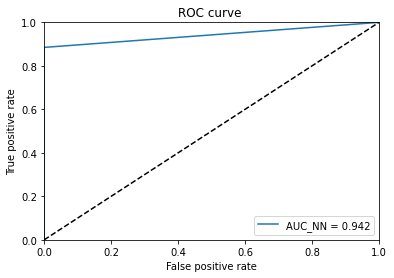

In [63]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# fpr, tpr
fpr, tpr, thresholds = roc_curve((1-a(data.float())>0.5).int(), labels,pos_label=1)
fpr1, tpr1, thresholds1 = roc_curve(np.ones(200), labels,pos_label=2)
# 计算auc
auc_NN = auc(fpr, tpr)  
auc_LR =roc_auc_score(labels,np.ones(200)) 
print(auc)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(fpr, tpr, label='AUC_NN = {:.3f}'.format(auc_NN))
# plt.plot(fpr1, tpr1, label='AUC_LR = {:.3f}'.format(auc_LR))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve ')
plt.legend(loc='best')
plt.show()

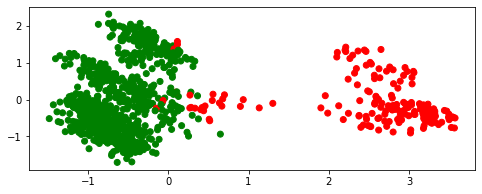

In [10]:
import pylab

import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA 
pca= PCA(n_components=5) 
pca_5d = pca.fit_transform(train_data)
c_ = {0:'r',1:'g'}
color = [c_[i] for i in train_label]
fig= plt.figure(figsize=(8,3)) 
plt.scatter(pca_5d[:,0],pca_5d[:,1],c = color)
plt.show()